In [1]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
%matplotlib inline

import argparse
import torchvision

### Simple VAE

In [2]:
class VAE(nn.Module):
    def __init__(self, dim_init=6075, dim_middle=1024, dim_latent=100):
        super(VAE, self).__init__()
        
        self.encode = nn.Sequential(
            nn.Linear(dim_init, dim_middle),
            nn.ReLU()
        )
        
        self.latent_mu = nn.Linear(dim_middle, dim_latent)
        self.latent_logsigma = nn.Linear(dim_middle, dim_latent)
        
        self.decode = nn.Sequential(
            nn.Linear(dim_latent, dim_middle),
            nn.ReLU()
        )

        self.reconstruction_mu = nn.Sequential(
            nn.Linear(dim_middle, dim_init),
            nn.Sigmoid()
        )
        
        self.reconstruction_logsigma = nn.Sequential(
            nn.Linear(dim_middle, dim_init),
            nn.Sigmoid()
        )
        
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = logsigma.exp()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        
        x_enc = self.encode(x)
        latent_mu = self.latent_mu(x_enc)
        latent_logsigma = self.latent_logsigma(x_enc)
        
        z = self.gaussian_sampler(latent_mu, latent_logsigma)
        
        x_hat = self.decode(z)
        
        reconstruction_mu = self.reconstruction_mu(x_hat)
        reconstruction_logsigma = self.reconstruction_logsigma(x_hat)
        
        return reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma

#### Useful functions

In [3]:
def KL_divergence(mu, logsigma):
    return - 0.5 * torch.sum(1 + 2 * logsigma - mu.pow(2) - logsigma.exp().pow(2), dim=1)

def log_likelihood(x, mu, logsigma):
    return torch.sum(- logsigma - 0.5 * np.log(2 * np.pi) - (mu - x).pow(2) / (2 * logsigma.exp().pow(2)), dim=1)

def loss_beta_vae(x, mu_gen, logsigma_gen, mu_latent, logsigma_latent, beta=1):
    return torch.mean(beta * KL_divergence(mu_latent, logsigma_latent) - log_likelihood(x, mu_gen, logsigma_gen))

#### Train $\beta$-VAE

In [82]:
import time
from IPython import display

def train(model, opt, scheduler, loss_beta_vae, train_loader, valid_loader, num_epochs=20, beta=1):
    train_loss = []
    valid_loss = []
    
    train_mean_loss = []
    valid_mean_loss = []
    
    for epoch in range(num_epochs):
        # a full pass over the training data:
        start_time = time.time()
        model.train(True)
        for (X_batch, y_batch) in train_loader:
            X_batch = X_batch.reshape(train_loader.batch_size, -1)
            if torch.cuda.is_available():
                reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma = \
                model.forward(X_batch.cuda())
                loss = loss_beta_vae(torch.FloatTensor(X_batch).cuda(), \
                                     reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma, beta)
                loss.backward()
                opt.step()
                opt.zero_grad()
                train_loss.append(loss.data.cpu().numpy())
            else:
                reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma = \
                model.forward(X_batch)
                loss = loss_beta_vae(torch.FloatTensor(X_batch), \
                                     reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma, beta)
                loss.backward()
                opt.step()
                opt.zero_grad()
                train_loss.append(loss.data.numpy())

        # a full pass over the validation data:
        model.train(False)
        with torch.no_grad():
            for (X_batch, y_batch) in valid_loader:
                X_batch = X_batch.reshape(valid_loader.batch_size, -1)
                if torch.cuda.is_available():
                    reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma = \
                    model.forward(X_batch.cuda())
                    loss = loss_beta_vae(torch.FloatTensor(X_batch).cuda(), reconstruction_mu, \
                                         reconstruction_logsigma, latent_mu, latent_logsigma, beta)
                    valid_loss.append(loss.data.cpu().numpy())
                else:
                    reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma = \
                    model.forward(X_batch)
                    loss = loss_beta_vae(torch.FloatTensor(X_batch), reconstruction_mu, \
                                         reconstruction_logsigma, latent_mu, latent_logsigma, beta)
                    valid_loss.append(loss.data.numpy())
                
        train_mean_loss.append(np.mean(train_loss[-len(train_loader) // train_loader.batch_size :]))
        valid_mean_loss.append(np.mean(valid_loss[-len(valid_loader) // valid_loader.batch_size :]))
        
        # update lr
        scheduler.step(valid_mean_loss[-1])
        # stop
        if opt.param_groups[0]['lr'] <= 1e-6:
            break
        
        # visualization of training
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))

        plt.title("Loss")
        plt.xlabel("#epoch")
        plt.ylabel("losses")
        plt.plot(train_mean_loss, 'b', label='Training loss')
        plt.plot(valid_mean_loss, 'r', label='Validation loss')
        plt.legend()
        plt.show()

        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            train_mean_loss[-1]))
        print("  validation loss (in-iteration): \t{:.6f}".format(
            valid_mean_loss[-1])) 

### mnist

In [83]:
batch_size = 4

mnist_train_set = torchvision.datasets.MNIST('./data/mnist/', download=True, train=True, \
                                            transform=torchvision.transforms.ToTensor())
mnist_test_set = torchvision.datasets.MNIST('./data/mnist/', download=True, train=False, \
                                            transform=torchvision.transforms.ToTensor())

In [99]:
mnist_train_loader = torch.utils.data.DataLoader(mnist_train_set, \
                                                 batch_size=batch_size, shuffle=True, drop_last=True)
mnist_test_loader = torch.utils.data.DataLoader(mnist_test_set, \
                                                batch_size=batch_size, shuffle=True, drop_last=True)

In [85]:
vae_model = VAE(28 * 28, 14 * 14, 100)
if torch.cuda.is_available():
    vae_model = vae_model.cuda()

optimizer = optim.Adam(vae_model.parameters(), lr=1e-2)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)

### vae

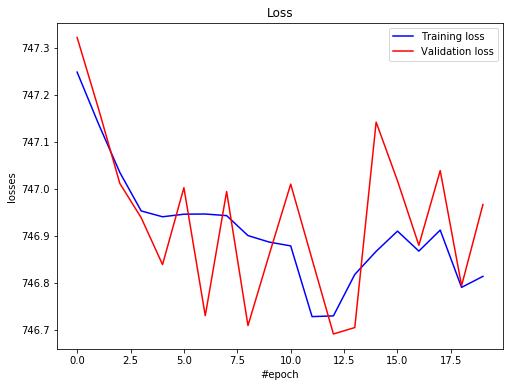

Epoch 20 of 20 took 475.324s
  training loss (in-iteration): 	746.813843
  validation loss (in-iteration): 	746.966492


In [86]:
train(vae_model, optimizer, scheduler, loss_beta_vae, mnist_train_loader, mnist_test_loader)

In [117]:
def plot_gallery(images, h, w, n_chan=3, n_row=3, n_col=6):
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        if n_chan == 1:
            plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            plt.xticks(())
            plt.yticks(())
        else:
            plt.imshow(images[i].reshape((h, w, n_chan)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            plt.xticks(())
            plt.yticks(())

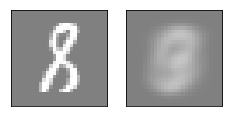

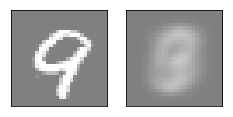

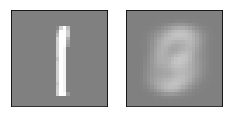

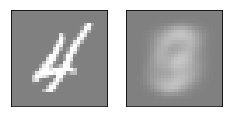

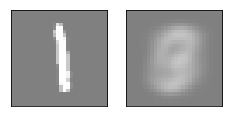

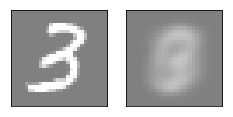

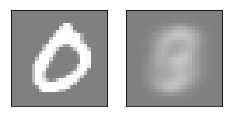

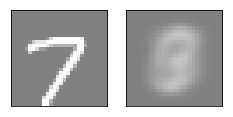

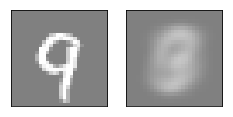

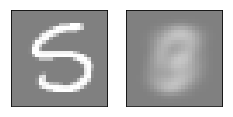

In [121]:
# reconstructions
image_h, image_w = 28, 28
vae_model.eval()
for j, data in enumerate(mnist_test_loader, 0):
    if torch.cuda.is_available():
        data = data[0].reshape(mnist_test_loader.batch_size, -1)
        input = data.cuda()
        reconstruction_mu, _, _, _ = vae_model(input)
        plot_gallery([data[0].numpy(), reconstruction_mu.data[0].cpu().numpy()], \
                     image_h, image_w, n_chan=1, n_row=1, n_col=2)
        if (j >= 9):
            break
    else:
        data = data[0].reshape(mnist_test_loader.batch_size, -1)
        input = data
        reconstruction_mu, _, _, _ = vae_model(input)
        plot_gallery([data[0].numpy(), reconstruction_mu.data[0].numpy()], \
                     image_h, image_w, n_chan=1, n_row=1, n_col=2)
        if (j >= 9):
            break

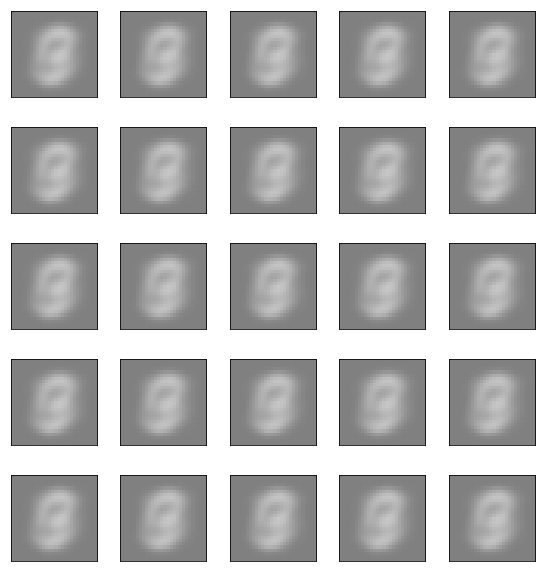

In [130]:
# sampling
z = np.random.randn(25, 10 * 10) * 0.5
if torch.cuda.is_available():
    torch_z = torch.FloatTensor(z).cuda()
    output = vae_model.reconstruction_mu(vae_model.decode(torch_z))
    plot_gallery(output.data.cpu().numpy(), image_h, image_w, n_chan=1, n_row=5, n_col=5)
else:
    torch_z = torch.FloatTensor(z)
    output = vae_model.reconstruction_mu(vae_model.decode(torch_z))
    plot_gallery(output.data.cpu().numpy(), image_h, image_w, n_chan=1, n_row=5, n_col=5)         